# Autoencoder for Satellite dataset

In [1]:
import pandas as pd
import numpy as np
from keras.models import Model,load_model
from keras.callbacks import ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
from keras import regularizers
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D
from keras.models import Model
from keras import backend as K

Using TensorFlow backend.


In [2]:
#read data
x_train = pd.read_csv('dataset/sat_train.csv')
x_test = pd.read_csv('dataset/sat_test.csv')
y_train = pd.read_csv('dataset/sat_train_label.csv')
y_train = np.asarray(y_train)
y_test = pd.read_csv('dataset/sat_test_label.csv')
y_test = np.asarray(y_test)

In [3]:
## Normalization
#x_train.max().max()
x_train = x_train.astype('float32') / 157.
x_test = x_test.astype('float32') / 157.

In [4]:
y_test

array([[3],
       [3],
       [4],
       ...,
       [5],
       [5],
       [5]])

# Basic Autoencoder

In [54]:
########### Basic Autoencoder ##########
input_dim = x_train.shape[1]
input_layer = Input(shape=(input_dim, ))

encoding_dim = 4
#learning_rate = 1e-7

encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# implenment an autoencoder, creat encoder and decoder

autoencoder = Model(input_layer, decoded)

encoder = Model(input_layer, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
                                             
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [55]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 36)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 148       
_________________________________________________________________
dense_15 (Dense)             (None, 36)                180       
Total params: 328
Trainable params: 328
Non-trainable params: 0
_________________________________________________________________


In [56]:
ae_train = autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=128,
                shuffle=False,
                validation_data=(x_test, x_test),
                verbose=0
                ).history

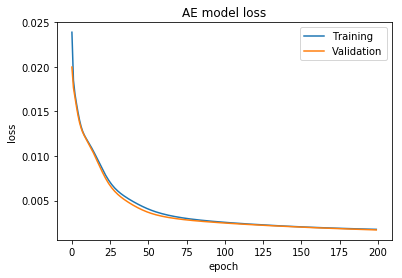

In [57]:
# AE loss
plt.plot(ae_train['loss'])
plt.plot(ae_train['val_loss'])
plt.title('AE model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [9]:
# create encoded data
encoded_data = encoder.predict(x_test)
#decoded_data = decoder.predict(encoded_data)

# transform to SOM input type
encoded_som = pd.DataFrame(encoded_data)
#decoded_som = pd.DataFrame(decoded_data)

In [10]:
nonzero = list(map(lambda i: any(encoded_data[:,i] != 0), range(encoded_data.shape[1])))
encoded_som_nonzero = pd.DataFrame(encoded_data[:,nonzero])
encoded_som_nonzero.to_csv(path_or_buf='output/sat_AE_encoded.csv',index= False)

# Sparse Autoencoder

In [48]:
########### Sparse Autoencoder ##########
input_dim = x_train.shape[1]
input_layer = Input(shape=(input_dim, ))

encoding_dim = 4
#learning_rate = 1e-7

encoded = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-7))(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# implenment an autoencoder, creat encoder and decoder

autoencoder = Model(input_layer, decoded)

encoder = Model(input_layer, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
                                             
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [49]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 36)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 148       
_________________________________________________________________
dense_13 (Dense)             (None, 36)                180       
Total params: 328
Trainable params: 328
Non-trainable params: 0
_________________________________________________________________


In [50]:
ae_train = autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=128,
                shuffle=False,
                validation_data=(x_test, x_test),
                verbose=0
                ).history

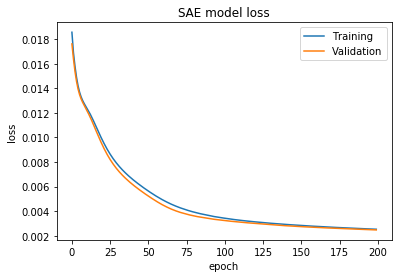

In [51]:
# SAE loss
plt.plot(ae_train['loss'])
plt.plot(ae_train['val_loss'])
plt.title('SAE model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [52]:
# create encoded data
encoded_data = encoder.predict(x_test)
#decoded_data = decoder.predict(encoded_data)

# transform to SOM input type
encoded_som = pd.DataFrame(encoded_data)
#decoded_som = pd.DataFrame(decoded_data)

In [53]:
nonzero = list(map(lambda i: any(encoded_data[:,i] != 0), range(encoded_data.shape[1])))
encoded_som_nonzero = pd.DataFrame(encoded_data[:,nonzero])
encoded_som_nonzero.to_csv(path_or_buf='output/sat_SAE_encoded.csv',index= False)

# Contractive Autoencoder

In [58]:
########### Contractive Autoencoder ##########
input_dim = x_train.shape[1]
input_layer = Input(shape=(input_dim, ))

encoding_dim = 4
#learning_rate = 1e-7

encoded = Dense(encoding_dim, activation='relu', name = 'encoded')(input_layer)

decoded = Dense(input_dim, activation='sigmoid')(encoded)

# implenment an autoencoder, creat encoder and decoder

autoencoder = Model(input_layer, decoded)

encoder = Model(input_layer, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

lam = 10e-7

def contractive_loss(y_pred, y_true):
    
        mse = K.mean(K.square(y_true - y_pred), axis=1)
        W = K.variable(value=autoencoder.get_layer('encoded').get_weights()[0])
        W = K.transpose(W)
        h = autoencoder.get_layer('encoded').output
        dh = h * (1 - h)
        contractive = lam * K.sum(dh**2 * K.sum(W**2, axis=1), axis=1)

        return mse + contractive
    
autoencoder.compile(optimizer='adadelta', loss= contractive_loss)

In [59]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 36)                0         
_________________________________________________________________
encoded (Dense)              (None, 4)                 148       
_________________________________________________________________
dense_16 (Dense)             (None, 36)                180       
Total params: 328
Trainable params: 328
Non-trainable params: 0
_________________________________________________________________


In [60]:
ae_train = autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                verbose=0
                ).history

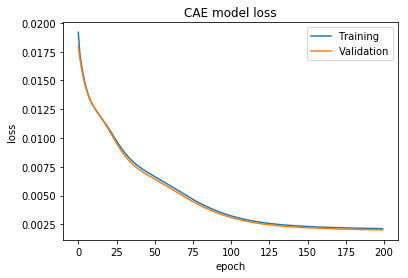

In [61]:
# CAE loss
plt.plot(ae_train['loss'])
plt.plot(ae_train['val_loss'])
plt.title('CAE model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [62]:
# create encoded data
encoded_data = encoder.predict(x_test)
#decoded_data = decoder.predict(encoded_data)

# transform to SOM input type
encoded_som = pd.DataFrame(encoded_data)
#decoded_som = pd.DataFrame(decoded_data)

In [63]:
nonzero = list(map(lambda i: any(encoded_data[:,i] != 0), range(encoded_data.shape[1])))
encoded_som_nonzero = pd.DataFrame(encoded_data[:,nonzero])
encoded_som_nonzero.to_csv(path_or_buf='output/sat_CAE_encoded.csv',index= False)

# Denoising Autoencoder

In [17]:
############ Denoising Autoencoder ###########

# add noise
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

input_dim = x_train.shape[1]
input_layer = Input(shape=(input_dim, ))

encoding_dim = 4
#learning_rate = 1e-7

encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# implenment an autoencoder, creat encoder and decoder

autoencoder = Model(input_layer, decoded)

encoder = Model(input_layer, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
                                             
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [18]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 36)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 148       
_________________________________________________________________
dense_8 (Dense)              (None, 36)                180       
Total params: 328
Trainable params: 328
Non-trainable params: 0
_________________________________________________________________


In [19]:
ae_train = autoencoder.fit(x_train_noisy, x_train,
                epochs=300,
                batch_size=128,
                shuffle=False,
                validation_data=(x_test_noisy, x_test),
                verbose = 0
                ).history

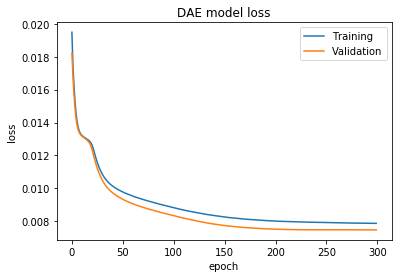

In [20]:
# DAE loss
plt.plot(ae_train['loss'])
plt.plot(ae_train['val_loss'])
plt.title('DAE model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [21]:
# create encoded data
encoded_data = encoder.predict(x_test)
#decoded_data = decoder.predict(encoded_data)

# transform to SOM input type
encoded_som = pd.DataFrame(encoded_data)
#decoded_som = pd.DataFrame(decoded_data)

In [22]:
nonzero = list(map(lambda i: any(encoded_data[:,i] != 0), range(encoded_data.shape[1])))
encoded_som_nonzero = pd.DataFrame(encoded_data[:,nonzero])
encoded_som_nonzero.to_csv(path_or_buf='output/sat_DAE_encoded.csv',index= False)

# Convolutional Autoencoder

In [23]:
input_dim = x_train.shape[1]

# tranform the input format, add a dimension
x_train_con = x_train.as_matrix()
x_train_con = np.reshape(x_train_con, (-1, input_dim, 1))
x_text_con = x_test.as_matrix()
x_text_con = np.reshape(x_text_con, (-1, input_dim, 1))

input_layer = Input(shape=(input_dim,1))

x = Conv1D(32, 3, activation='relu', padding='same')(input_layer)
x = MaxPooling1D(2, padding='same')(x)
x = Conv1D(16, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(2, padding='same')(x)
x = Conv1D(2, 3, activation='relu', padding='same')(x)
encoded = MaxPooling1D(2, padding='same')(x)


x = Conv1D(2, 3, activation='relu', padding='same')(encoded)
x = UpSampling1D(2)(x)
x = Conv1D(16, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
x = Conv1D(32, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
decoded = Conv1D(1, 5, activation='sigmoid')(x)

autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [24]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 36, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 36, 32)            128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 18, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 18, 16)            1552      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 9, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 9, 2)              98        
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 5, 2)              0         
__________

In [25]:
ae_train = autoencoder.fit(x_train_con, x_train_con,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(x_text_con, x_text_con),
                verbose=0
                ).history

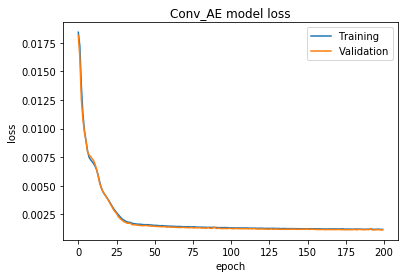

In [26]:
# Con_AE loss
plt.plot(ae_train['loss'])
plt.plot(ae_train['val_loss'])
plt.title('Conv_AE model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [27]:
encoded_data = encoder.predict(x_text_con)

In [28]:
encoded_data.shape

(2000, 5, 2)

In [29]:
# create encoded data

encoded_data = encoded_data.reshape(-1, 5*2)

# transform to SOM input type
encoded_som = pd.DataFrame(encoded_data)
#decoded_som = pd.DataFrame(decoded_data)

In [30]:
nonzero = list(map(lambda i: any(encoded_data[:,i] != 0), range(encoded_data.shape[1])))
encoded_som_nonzero = pd.DataFrame(encoded_data[:,nonzero])
encoded_som_nonzero.to_csv(path_or_buf='output/sat_ConAE_encoded.csv',index= False)